In [19]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [ ]:
#dataset
#https://www.kaggle.com/datasets/aaryapandya/earthquake-detection/data
df = pd.read_csv("Data.csv")
df = df[['aX', 'aY', 'aZ', "Result"]]

print(df.head())

      aX    aY     aZ  Result
0  -2176   996 -16868       1
1  -2176   996 -16868       1
2  -6564 -1340 -13532       1
3     -8  2316 -23504       1
4  17064 -5608  10432       1


In [7]:
earthquake = df[df["Result"] == 1].iloc[:28600].reset_index(drop=True)
no_earthquake = df[df["Result"] == 0].iloc[:28600].reset_index(drop=True)


In [9]:
earthquake_X = earthquake[['aX']]
earthquake_Y = earthquake[['aY']]
earthquake_Z = earthquake[['aZ']]

no_earthquake_X = no_earthquake[['aX']]
no_earthquake_Y = no_earthquake[['aY']]
no_earthquake_Z = no_earthquake[['aZ']]

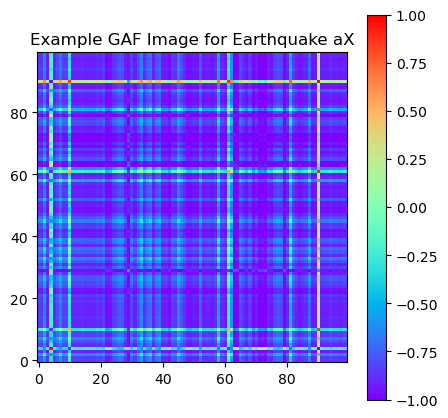

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField

def convert_to_gaf_images(series, image_size=100):
    """
    Convert time series data into Gramian Angular Field (GAF) images.
    
    Parameters:
        series (pd.Series or np.array): 1D array of time series data.
        image_size (int): Number of time steps per image.
        
    Returns:
        gaf_images (list): List of GAF images.
    """
    gaf = GramianAngularField(method='summation', image_size=image_size)
    series = series.to_numpy().reshape(-1, image_size)  # Reshape into (num_samples, image_size)
    gaf_images = gaf.fit_transform(series)  # Convert to GAF images
    return gaf_images

# Convert accelerometer data into GAF images (100 time steps per image)
earthquake_X_gaf = convert_to_gaf_images(earthquake_X['aX'])
earthquake_Y_gaf = convert_to_gaf_images(earthquake_Y['aY'])
earthquake_Z_gaf = convert_to_gaf_images(earthquake_Z['aZ'])

no_earthquake_X_gaf = convert_to_gaf_images(no_earthquake_X['aX'])
no_earthquake_Y_gaf = convert_to_gaf_images(no_earthquake_Y['aY'])
no_earthquake_Z_gaf = convert_to_gaf_images(no_earthquake_Z['aZ'])

# Plot an example
plt.figure(figsize=(5, 5))
plt.imshow(earthquake_X_gaf[0], cmap='rainbow', origin='lower')
plt.title("Example GAF Image for Earthquake aX")
plt.colorbar()
plt.show()


In [12]:
X = np.concatenate((earthquake_X_gaf, earthquake_Y_gaf, earthquake_Z_gaf, 
                    no_earthquake_X_gaf, no_earthquake_Y_gaf, no_earthquake_Z_gaf))

y = np.concatenate((np.ones(len(earthquake_X_gaf)), np.ones(len(earthquake_Y_gaf)), np.ones(len(earthquake_Z_gaf)),
                    np.zeros(len(no_earthquake_X_gaf)), np.zeros(len(no_earthquake_Y_gaf)), np.zeros(len(no_earthquake_Z_gaf))))

# Normalize pixel values (0-1 range) and reshape for CNN input
X = X.astype('float32')
X = np.expand_dims(X, axis=-1)  # Add channel dimension for CNN input
X = np.repeat(X, 3, axis=-1)  # Convert grayscale to 3 channels (for ResNet)

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert labels to categorical (one-hot encoding)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

In [13]:
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

# Freeze the base model's layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for classification
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(2, activation='softmax')(x)  # Binary classification (earthquake or not)

# Create final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 106, 106,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 50, 50,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 52, 52,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 25, 25,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 25, 25,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 25, 25,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 25, 25,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 25, 25,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 25, 25,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 27, 27,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 25, 25,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 25, 25,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 25, 25,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 25, 25,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 25, 25,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 25, 25,    │          0 │ conv2_block1_0_c

 Total params: 24,089,858 (91.90 MB)

 Trainable params: 525,058 (2.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5,
    batch_size=32,
    verbose=1
)

# Save the trained model
model.save("resnet_gaf_model.h5")


Epoch 1/10


ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=True
  • mask=None

In [15]:
# Create a feature extractor model
feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)

# Extract features from training and test sets
train_features = feature_extractor.predict(X_train)
test_features = feature_extractor.predict(X_test)

# Save extracted features for later use
np.save("train_features.npy", train_features)
np.save("test_features.npy", test_features)
np.save("train_labels.npy", np.argmax(y_train, axis=1))
np.save("test_labels.npy", np.argmax(y_test, axis=1))

print("Feature extraction complete.")


43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step
Feature extraction complete.


In [ ]:
# Load extracted features and labels
train_features = np.load("train_features.npy")
test_features = np.load("test_features.npy")
train_labels = np.load("train_labels.npy")
test_labels = np.load("test_labels.npy")

# Standardize the features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

# Apply ICA to reduce dimensionality to 64
ica = FastICA(n_components=128, random_state=42)
train_features_ica = ica.fit_transform(train_features)
test_features_ica = ica.transform(test_features)

print(f"Reduced train features shape: {train_features_ica.shape}")
print(f"Reduced test features shape: {test_features_ica.shape}")

Reduced train features shape: (1372, 64)
Reduced test features shape: (344, 64)


In [20]:
# Reshape deep features for BiLSTM (timesteps = 1 since each sample is a feature vector)
train_features_ica = np.expand_dims(train_features_ica, axis=1)
test_features_ica = np.expand_dims(test_features_ica, axis=1)

train_labels = to_categorical(train_labels, num_classes=2)
test_labels = to_categorical(test_labels, num_classes=2)

print(f"Train data shape: {train_features_ica.shape}, Labels shape: {train_labels.shape}")
print(f"Test data shape: {test_features_ica.shape}, Labels shape: {test_labels.shape}")

Train data shape: (1372, 1, 64), Labels shape: (1372, 2)
Test data shape: (344, 1, 64), Labels shape: (344, 2)


In [ ]:
# Define BiLSTM model
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=False, dropout=0.3), input_shape=(1, 64)),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')  # Binary classification
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(
    train_features_ica, train_labels,
    validation_data=(test_features_ica, test_labels),
    epochs=10,
    batch_size=32,
    verbose=1
)

# Save model
model.save("bilstm_ica_model.h5")

Epoch 1/20


/opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5671 - loss: 0.6793 - val_accuracy: 0.7297 - val_loss: 0.6124
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8277 - loss: 0.5345 - val_accuracy: 0.7645 - val_loss: 0.5028
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8466 - loss: 0.3890 - val_accuracy: 0.7645 - val_loss: 0.4822
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8911 - loss: 0.2878 - val_accuracy: 0.7674 - val_loss: 0.5119
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8861 - loss: 0.2923 - val_accuracy: 0.7674 - val_loss: 0.5378
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8870 - loss: 0.2654 - val_accuracy: 0.7616 - val_loss: 0.5477
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8720 - loss: 0.2926 - val_accuracy: 0.7703 - val_loss: 0.5351
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9087 - loss: 0.2333 - val_accuracy: 0.7616 - val_loss: 0.5481
Epo